In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../data/.DS_Store
../data/influenza_predictor2.csv
../data/influenza_predictor.csv


In [ ]:
!pip install prophet

In [ ]:
# !pip install pystan==2.19.1.1
# !pip install fbprophet

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from vaccine_predictor.params import *
# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

# Load the data
data = pd.read_csv(f'{RAW_DATA}/influenza_predictor2.csv')
data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Vaccination type,Event date,Patient ID,Date of birth,Event done at ID,Patient Count
0,Influenza Vaccine 1,21-Oct-1993,19579730,08-Feb-2028,E87750,1
1,Influenza Vaccine 1,22-Nov-1996,19579289,13-May-1937,E87750,1
2,Influenza Vaccine 1,31-Oct-1997,17412404,30-Dec-1982,E87750,1
3,Influenza Vaccine 1,26-Nov-1997,17412911,27-Feb-1950,E87750,1
4,Influenza Vaccine 1,11-Dec-1997,59039995,06-Jun-1993,NaN,1


In [65]:
data.drop(columns='Patient Count', inplace=True)

In [66]:
data.columns = ["vaccine", "ds", "patient_id", "dob", "location"]

In [67]:
data.head()

,vaccine,ds,patient_id,dob,location
0,Influenza Vaccine 1,21-Oct-1993,19579730,08-Feb-2028,E87750
1,Influenza Vaccine 1,22-Nov-1996,19579289,13-May-1937,E87750
2,Influenza Vaccine 1,31-Oct-1997,17412404,30-Dec-1982,E87750
3,Influenza Vaccine 1,26-Nov-1997,17412911,27-Feb-1950,E87750
4,Influenza Vaccine 1,11-Dec-1997,59039995,06-Jun-1993,NaN


In [68]:
data['ds'] = pd.to_datetime(data['ds'], format="%d-%b-%Y")
data['dob'] = pd.to_datetime(data['dob'], format="%d-%b-%Y")

In [69]:
practice_code = "E87750"

In [70]:
data = data[data['location'] == practice_code]

In [72]:
data['age_at_vaccine'] = data['ds'].dt.year - data['dob'].dt.year

In [73]:
data.head()

,vaccine,ds,patient_id,dob,location,age_at_vaccine
0,Influenza Vaccine 1,1993-10-21,19579730,2028-02-08,E87750,-35
1,Influenza Vaccine 1,1996-11-22,19579289,1937-05-13,E87750,59
2,Influenza Vaccine 1,1997-10-31,17412404,1982-12-30,E87750,15
3,Influenza Vaccine 1,1997-11-26,17412911,1950-02-27,E87750,47
5,Influenza Vaccine 1,1998-10-07,19579079,1938-02-03,E87750,60


In [74]:
data = data[data['age_at_vaccine']> 0]

<Axes: xlabel='age_at_vaccine', ylabel='Count'>

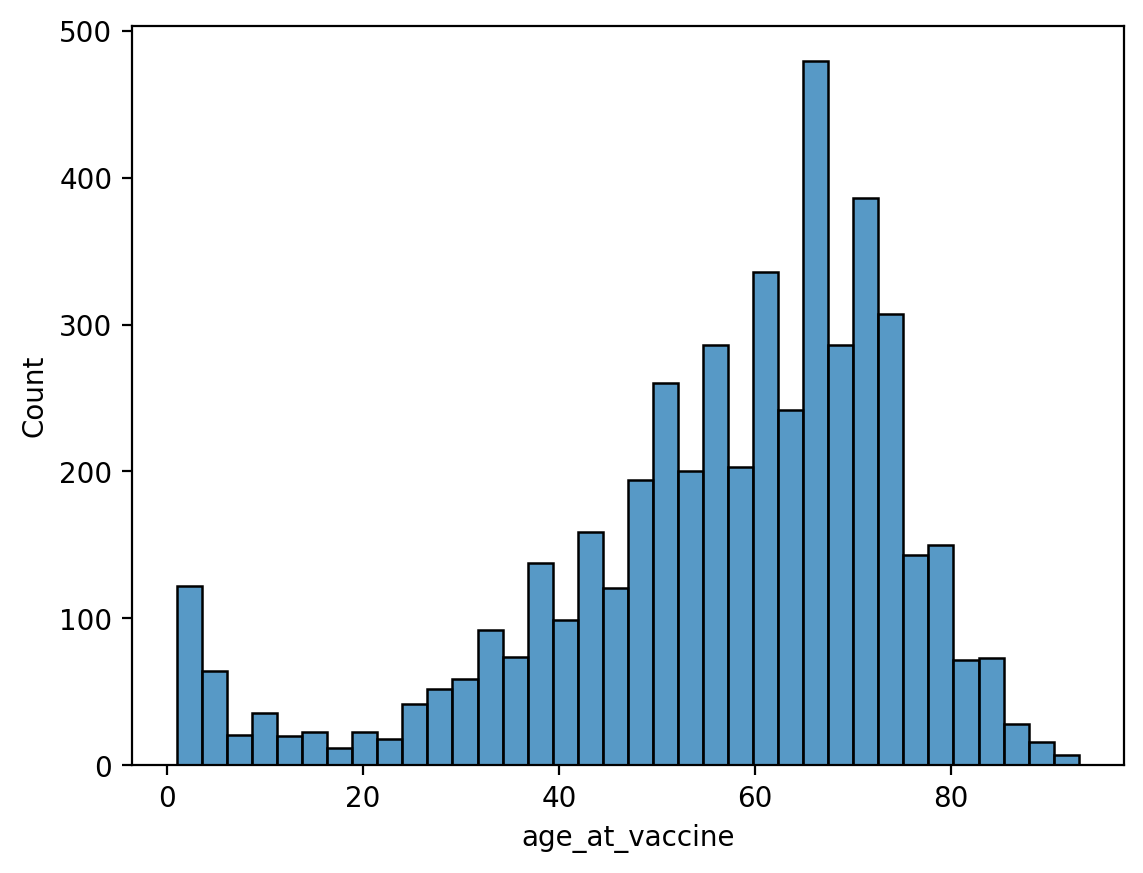

In [76]:
import seaborn as sns 
sns.histplot(data=data, x='age_at_vaccine')

In [77]:
def to_timeseries(df, column, time_period="D"):
    # Resample and count occurrences in each period
    m_count = df.resample(time_period, on=column).size()

    # Convert to DataFrame
    m_count_df = m_count.reset_index()

    # Rename columns
    m_count_df.columns = ["ds", "y"]

    return m_count_df

ts = to_timeseries(data, 'ds', "M")
ts.set_index('ds', inplace=True)
ts.head()

,y
ds,
1993-10-31,2
1993-11-30,3
1993-12-31,0
1994-01-31,0
1994-02-28,0


<Axes: xlabel='ds', ylabel='y'>

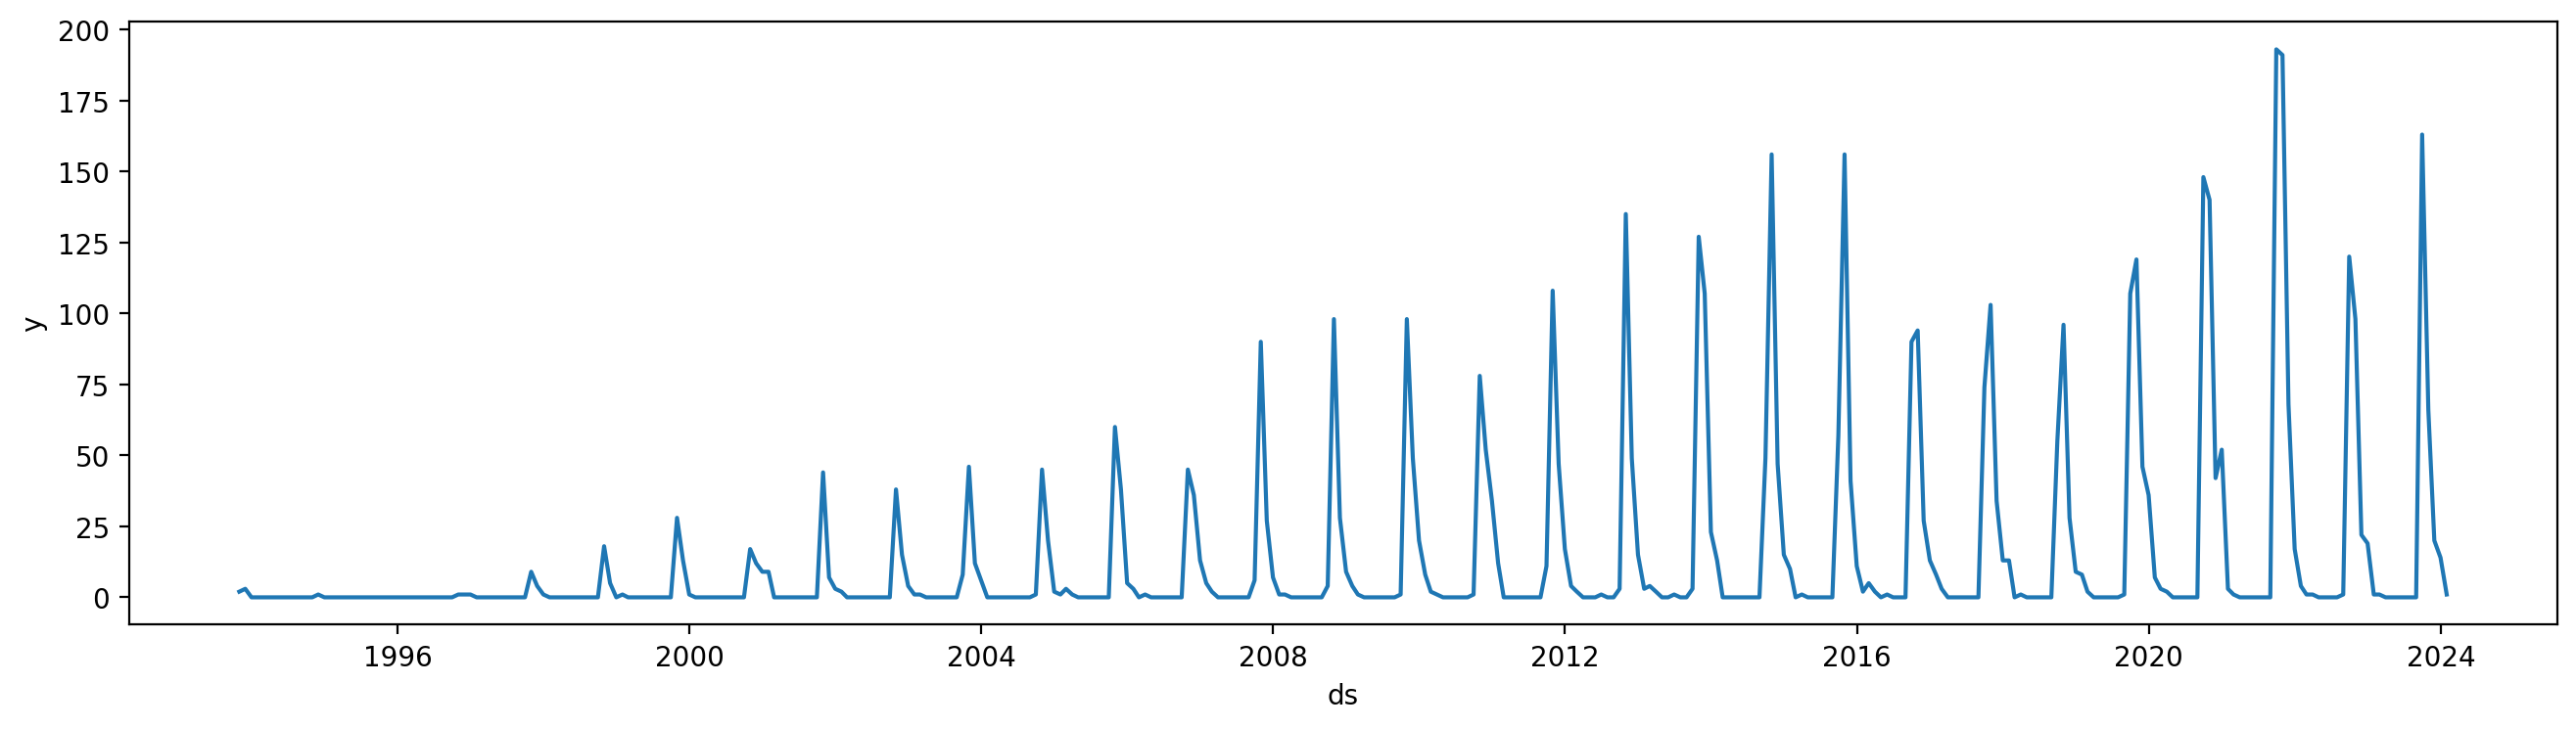

In [78]:
plt.figure(figsize=(16,4))
sns.lineplot(data=ts, x=ts.index, y='y')

In [79]:
ts.reset_index(inplace=True)

In [82]:
ts.head()

,ds,y
0,1993-10-31,2
1,1993-11-30,3
2,1993-12-31,0
3,1994-01-31,0
4,1994-02-28,0


In [101]:
# Create a Prophet object and fit it to the data
model = Prophet()
model.fit(ts)

20:49:46 - cmdstanpy - INFO - Chain [1] start processing
20:49:46 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
# Create a future dataframe
future = model.make_future_dataframe(periods=12, freq='M', include_history=False)
future.head()

,ds
0,2024-02-29
1,2024-03-31
2,2024-04-30
3,2024-05-31
4,2024-06-30


In [103]:
# Make predictions for the future dates
forecast = model.predict(future)
new = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

/Users/janduplessis/.pyenv/versions/3.10.6/envs/vaccine/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/janduplessis/.pyenv/versions/3.10.6/envs/vaccine/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


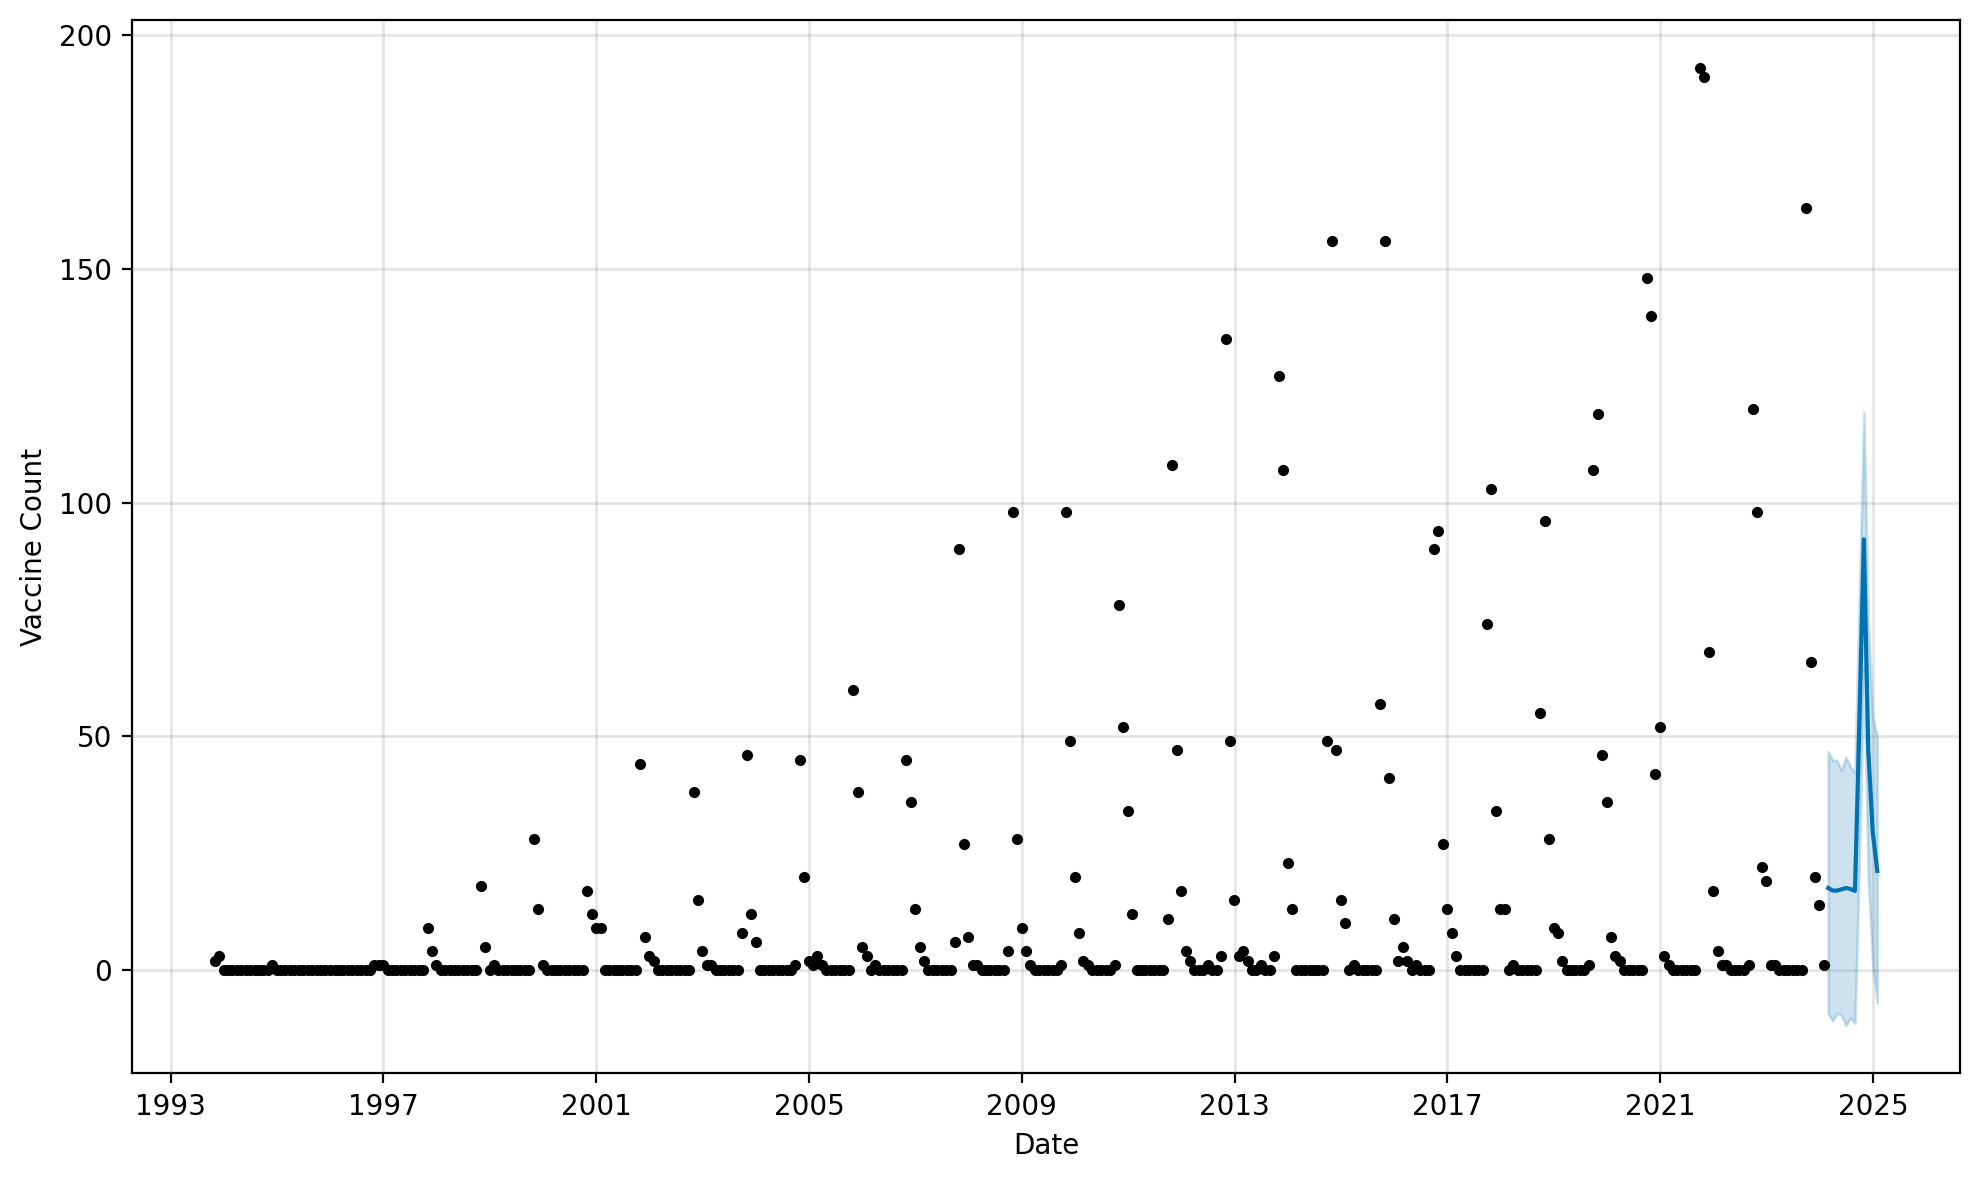

In [104]:
# Visualize the predictions
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Vaccine Count')
plt.show()

In [106]:
new

,ds,yhat,yhat_lower,yhat_upper
0,2024-02-29,17.546044,-9.369287,46.737354
1,2024-03-31,16.995670,-10.850606,44.913400
2,2024-04-30,17.000936,-9.207544,44.816770
3,2024-05-31,17.275695,-9.736893,42.658195
4,2024-06-30,17.551679,-11.872123,45.574803
5,2024-07-31,17.349135,-10.199736,43.503556
6,2024-08-31,16.927742,-11.379072,42.099502
7,2024-09-30,52.304537,23.087499,79.911978
8,2024-10-31,92.160188,64.710659,119.313752
9,2024-11-30,47.267962,19.922088,75.021032


In [107]:
new['yhat_lower'].sum()

29.132067253009197

In [108]:
new['yhat'].sum()

363.1023475608298

In [109]:
new['yhat_upper'].sum()

688.4570347166157

In [105]:
filtered['yhat_lower'].sum()

3014.8375653779804

## Prophet with Additional Regressors

In [ ]:
future = df[df.ds > '2016-09-01']
train = df[df.ds <= '2016-09-01']

In [ ]:
model = Prophet()
model.add_regressor('vaccine')
model.fit(train)

In [ ]:
future.drop(columns = 'y', inplace= True)

In [ ]:
future.tail()

In [ ]:
# Make predictions for the future dates
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Visualize the predictions
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()